<a href="https://colab.research.google.com/github/HongheeLee/simpson-image-classification/blob/main/Simpson_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/"My Drive"/Parrot/train.zip -d /content/drive/"My Drive"/Parrot
!unzip /content/drive/"My Drive"/Parrot/test.zip -d /content/drive/"My Drive"/Parrot 

In [ ]:
#hyp parameters
data_path = "/content/drive/My Drive/Parrot/train"

categories = ["bart", "charles_montgomery", "krusty", "lisa_simpson", "marge_simpson",
              "milhouse_van_houten", "moe_szyslak", "ned_flanders", "principal_skinner"]
num_classes = len(categories)

In [ ]:
# 이미지 크기 지정 
image_w = 64 
image_h = 64
pixels = image_w * image_h * 3

In [ ]:
# 이미지 데이터 읽어 들이기 
X = []
Y = []
for idx, cat in enumerate(categories):
    # 레이블 지정 
    label = [0 for i in range(num_classes)]
    label[idx] = 1
    # 이미지 
    img_dir = data_path + "/" + cat
    files = glob.glob(img_dir+"/*.jpg")
    for i, f in enumerate(files):
        img = Image.open(f) 
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)      # numpy 배열로 변환
        X.append(data)
        Y.append(label)
        if i % 10 == 0:
           print(i, "\n", data)
X = np.array(X)
Y = np.array(Y)


## 데이터 로드 및 데이터 형태 확인

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/Parrot/image_data.npy", allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

(8436, 64, 64, 3)
8436
x_train shape :  (8436, 64, 64, 3)
y_train shape :  (8436, 9)
x_test shape :  (2812, 64, 64, 3)
y_test shape :  (2812, 9)


In [ ]:
def draw_data(data, axis = 5):
  len_data = len(data)
  size = axis**2
  random_int = np.random.randint(low = 0, high = len_data, size = size)
  for i in range(0, size):
    plt.subplot(axis, axis, i + 1)
    plt.imshow(data[random_int[i]], cmap=plt.get_cmap('Purples'))

  plt.show()

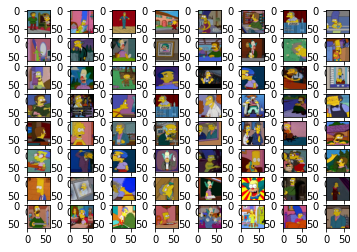

In [ ]:
draw_data(X_train, 8)

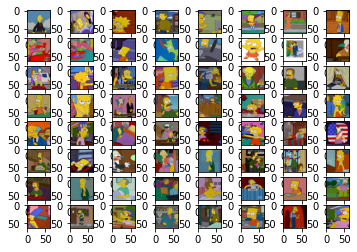

In [ ]:
draw_data(X_test, 8)

In [ ]:
print(X_train.min())
print(X_train.max())
print(y_train.min())
print(y_train.max())

0.0
1.0
0
1


In [ ]:
print("y_train에 관한 정보입니다.")
print(y_train)
print(len(y_train))
print(y_train.min())
print(y_train.max())

y_train에 관한 정보입니다.
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
8436
0
1


In [ ]:
#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
TRAIN_PATH = "/content/drive/My Drive/Parrot/train"

train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.2)

batch_size = 32
input_shape = (32,32)

generator_train = train_datagen.flow_from_directory(directory=TRAIN_PATH,
                                              target_size=input_shape,
                                              shuffle=True,
                                              batch_size = batch_size,
                                              subset="training"
                                              )

generator_validate = train_datagen.flow_from_directory(directory=TRAIN_PATH,
                                                 target_size=input_shape,
                                                 batch_size = batch_size,
                                                 shuffle=False,
                                                 subset="validation"
                                                 )
steps_train = generator_train.n / batch_size
steps_validate = generator_validate.n / batch_size

cls_train = generator_train.classes
cls_validate = generator_validate.classes

num_classes = generator_train.num_classes


Found 9003 images belonging to 9 classes.
Found 2245 images belonging to 9 classes.


## CNN 생성

In [ ]:
tf.keras.backend.clear_session()

model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Conv2D(32, (3,3), input_shape = (64, 64, 3), strides = (1,1), padding ='same', activation = 'relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_1.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_1.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_1.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_1.add(tf.keras.layers.Dropout(0.7))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_1.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

model_1.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9

In [ ]:
hist1 = model_1.fit_generator(
        generator_train,
        epochs= 30,
        validation_data=generator_validate,
        validation_steps=steps_validate)

In [ ]:
hist1 = model_1.fit(X_train, y_train, validation_split = 0.2, epochs = 30, batch_size = 64)

Epoch 1/30
106/106 [==============================] - 1s 12ms/step - loss: 1.9794 - accuracy: 0.2447 - val_loss: 1.6437 - val_accuracy: 0.4254
Epoch 2/30
106/106 [==============================] - 1s 10ms/step - loss: 1.6267 - accuracy: 0.4173 - val_loss: 1.3220 - val_accuracy: 0.5557
Epoch 3/30
106/106 [==============================] - 1s 9ms/step - loss: 1.3896 - accuracy: 0.5176 - val_loss: 1.2567 - val_accuracy: 0.5658
Epoch 4/30
106/106 [==============================] - 1s 10ms/step - loss: 1.2029 - accuracy: 0.5698 - val_loss: 1.0080 - val_accuracy: 0.6819
Epoch 5/30
106/106 [==============================] - 1s 9ms/step - loss: 1.0674 - accuracy: 0.6279 - val_loss: 0.8948 - val_accuracy: 0.7050
Epoch 6/30
106/106 [==============================] - 1s 10ms/step - loss: 0.9698 - accuracy: 0.6652 - val_loss: 0.7989 - val_accuracy: 0.7222
Epoch 7/30
106/106 [==============================] - 1s 9ms/step - loss: 0.8804 - accuracy: 0.6965 - val_loss: 0.7085 - val_accuracy: 0.7565
Ep

In [ ]:
score_1 = model_1.evaluate(X_test, y_test, verbose = 0)
print("Simple CNN Error : %.2f%%" % (100-score_1[1]*100))
print("Simple CNN Accuracy : %.2f%%" % (score_1[1]*100))

Simple CNN Error : 11.88%
Simple CNN Accuracy : 88.12%


In [ ]:
# 모델 저장하기
model_1_file = model_dir + "/model_1.hdf5"
if not os.path.exists(model_dir):
        os.mkdir(model_dir)
model_1.save_(model_1_file)

## 그래프 그리기

In [ ]:
def acc_loss_plot(hist):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='upper left')

  acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc = ' upper right')

  plt.show()

Simple CNN fitting


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


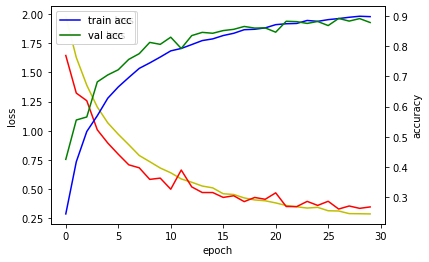

In [ ]:
print("Simple CNN fitting")
acc_loss_plot(hist1)

In [ ]:
tf.keras.backend.clear_session()

model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3,3), input_shape = (64, 64, 3), strides = (1,1), padding ='same', activation = 'relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_2.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_2.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_2.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding ='same', activation = 'relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
model_2.add(tf.keras.layers.Dropout(0.7))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_2.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

model_2.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=30, 
        zoom_range = 0.3,
        width_shift_range=0.3, 
        height_shift_range=0.3,
        horizontal_flip=True, 
        vertical_flip=True) 

datagen.fit(X_train)

In [ ]:
print(X_train.shape)
print(X_train.shape[0])
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

(8436, 64, 64, 3)
8436
x_train shape :  (8436, 64, 64, 3)
y_train shape :  (8436, 9)
x_test shape :  (2812, 64, 64, 3)
y_test shape :  (2812, 9)


In [ ]:
hist2=model_2.fit(datagen.flow(X_train, y_train, batch_size=64),
          steps_per_epoch=len(X_train) /64, epochs=30, validation_data = (X_test, y_test))

Epoch 1/30
132/131 [==============================] - 10s 78ms/step - loss: 3.8622 - accuracy: 0.1234 - val_loss: 2.1851 - val_accuracy: 0.1607
Epoch 2/30
132/131 [==============================] - 10s 76ms/step - loss: 2.1940 - accuracy: 0.1377 - val_loss: 2.1807 - val_accuracy: 0.1561
Epoch 3/30
132/131 [==============================] - 10s 77ms/step - loss: 2.1872 - accuracy: 0.1394 - val_loss: 2.1852 - val_accuracy: 0.1451
Epoch 4/30
132/131 [==============================] - 10s 76ms/step - loss: 2.1877 - accuracy: 0.1450 - val_loss: 2.1862 - val_accuracy: 0.1479
Epoch 5/30
132/131 [==============================] - 10s 76ms/step - loss: 2.1830 - accuracy: 0.1510 - val_loss: 2.1730 - val_accuracy: 0.1636
Epoch 6/30
132/131 [==============================] - 10s 77ms/step - loss: 2.1820 - accuracy: 0.1441 - val_loss: 2.1767 - val_accuracy: 0.1831
Epoch 7/30
132/131 [==============================] - 10s 76ms/step - loss: 2.1802 - accuracy: 0.1477 - val_loss: 2.1595 - val_accuracy:

Simple CNN fitting


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


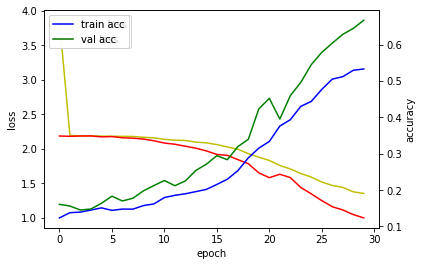

In [ ]:
print("Simple CNN fitting")
acc_loss_plot(hist2)

In [ ]:
score_2 = model_1.evaluate(X_test, y_test, verbose = 0)
print("Simple CNN Error : %.2f%%" % (100-score_2[1]*100))
print("Simple CNN Accuracy : %.2f%%" % (score_2[1]*100))

Simple CNN Error : 35.53%
Simple CNN Accuracy : 64.47%


In [ ]:
# 모델 저장하기
model_2_file = model_dir + "/model_2.h5"
if not os.path.exists(model_dir):
        os.mkdir(model_dir)
model_2.save(model_2_file)

In [ ]:
from keras.optimizers import SGD, Adam 
from keras.layers import Activation

tf.keras.backend.clear_session()
model_3 = Sequential()
model_3.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
model_3.add(Activation('relu'))
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(256, (3, 3), padding='same')) 
model_3.add(Activation('relu'))
model_3.add(Conv2D(256, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(1024))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.6))
model_3.add(Dense(9, activation='softmax'))
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_3.summary()

model_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=30, 
        zoom_range = 0.3,
        width_shift_range=0.3, 
        height_shift_range=0.3,
        horizontal_flip=True, 
        vertical_flip=True) 

datagen.fit(X_train)

In [ ]:
hist3=model_3.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) /128, epochs=100, validation_data = (X_test, y_test))

Epoch 1/100
66/65 [==============================] - 10s 151ms/step - loss: 2.1911 - accuracy: 0.1302 - val_loss: 2.1861 - val_accuracy: 0.1579
Epoch 2/100
66/65 [==============================] - 10s 148ms/step - loss: 2.1551 - accuracy: 0.1641 - val_loss: 2.1011 - val_accuracy: 0.2464
Epoch 3/100
66/65 [==============================] - 10s 146ms/step - loss: 2.0968 - accuracy: 0.2185 - val_loss: 2.0257 - val_accuracy: 0.2461
Epoch 4/100
66/65 [==============================] - 10s 147ms/step - loss: 2.0539 - accuracy: 0.2338 - val_loss: 1.9543 - val_accuracy: 0.2877
Epoch 5/100
66/65 [==============================] - 10s 146ms/step - loss: 2.0202 - accuracy: 0.2502 - val_loss: 1.8935 - val_accuracy: 0.3101
Epoch 6/100
66/65 [==============================] - 10s 149ms/step - loss: 1.9872 - accuracy: 0.2703 - val_loss: 1.8228 - val_accuracy: 0.3940
Epoch 7/100
66/65 [==============================] - 10s 147ms/step - loss: 1.9287 - accuracy: 0.3016 - val_loss: 1.7020 - val_accuracy:

In [ ]:
score_3 = model_3.evaluate(X_test, y_test, verbose = 0)
print("Simple CNN Error : %.2f%%" % (100-score_3[1]*100))
print("Simple CNN Accuracy : %.2f%%" % (score_3[1]*100))

Simple CNN Error : 5.87%
Simple CNN Accuracy : 94.13%


Simple CNN fitting


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


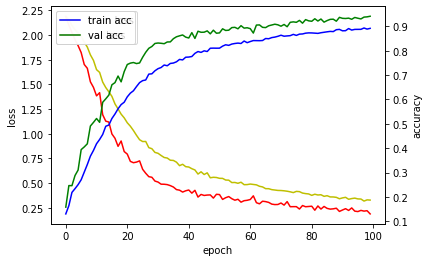

In [ ]:
print("Simple CNN fitting")
acc_loss_plot(hist3)

In [ ]:
# 모델 저장하기
model_3_file = model_dir + "/model_3.h5"
if not os.path.exists(model_dir):
        os.mkdir(model_dir)
model_3.save(model_3_file)

### 모델 테스트 하기

In [ ]:
# npy 파일엔 이미지 이름 없어서 이미지 파일 이름 따로 읽어오기
filenames = []
test_path = "/content/drive/My Drive/Parrot/test"
files = glob.glob(test_path+"/*.*")
for f in files:
    filenames.append(f.split('/')[6])
filenames.sort()
filenames[1:10]

In [ ]:
# npy 파일 불러와서 테스트하기
test_img = np.load("/content/drive/My Drive/Parrot/test_image.npy", allow_pickle=True)
Z = test_img.astype(float) / 255
result = []
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
prediction = model_1.predict(X)
for i in prediction:
    ans = i.argmax()  # 예측 레이블
    result.append(categories[ans])
    df = pd.DataFrame({'files' : filenames, 'pred': result})
df.to_csv("/content/drive/My Drive/Parrot/test.csv")
print(df)

In [ ]:
# 드라이브에서 파일 하나하나 읽으면서 테스트하기
test_path = "/content/drive/My Drive/Parrot/test"
K = []
filenames = []
result = []
files = glob.glob(test_path+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f.split('/')[6])
    K.append(data.astype(float) / 255)
    print(i)
K = np.array(K)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(type(K))
print(filenames[1:10])

<class 'numpy.ndarray'>
['test13712.jpg', 'test18647.jpg', 'test28960.jpg', 'test11688.jpg', 'test11850.jpg', 'test11111.jpg', 'test14096.jpg', 'test21763.jpg', 'test23174.jpg']


In [ ]:
model_final = tf.keras.models.load_model(model_3_file)
prediction = model_final.predict(K)
for i in prediction:
    ans = i.argmax()  # 예측 레이블
    result.append(categories[ans])


In [ ]:
# 정답지 작성하기
df = pd.DataFrame({'files' : filenames, 'pred': result})
df = df.sort_values(by='files')
df = df.reset_index(drop=True)
df.to_csv("/content/drive/My Drive/Parrot/model_3.csv")
print(df)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
